# <img style="float: left; padding-right: 10px; width: 45px" src="iacs.png"> S-109A Introduction to Data Science

## Final Project: Predicting the 2018 World Cup

**Harvard University**<br/>
**Summer 2018**<br/>
**Team**: Bruno Janota, Hans Chacko

<hr style="height:2pt">

### Project Overview

The goal of this project will be to leverage various sources of team/player data, historical international match results, historical FIFA rankings, and betting odds to construct a 2018 FIFA World Cup prediction model. The model will predict a win, loss, or draw match outcome for historical international matches from 1993 to 2018 divided into a training and testing set and evaluate those predictions against the baseline of predictions from simply incorporating FIFA ranking as a naïve measure of team strength (i.e. the team with a higher ranking should win). In addition to predicting historical international matches, the classification model will also be used to predict the outcome of the 2018 FIFA World Cup. 

The project will be split into three parts:
1.	Combine the international match outcome and FIFA rankings data sets for matches between 1993 and 2018. Perform some basic feature engineering to add additional features. Lastly, perform a 70/30% train/test set split and evaluate the performance of a Random Forest model on the overall classification accuracy on the test set. This will be the baseline model.
2.	Replace the FIFA rankings in Part 1 with an Elo based scoring model and assess improvement, if any, on the overall classification accuracy on the same test set used in part 1.
3.	The optimal combination of features from parts 1 and 2 (may include FIFA rank, Elo score, or both) will be used to train a variety of classification models (Random Forest, xgboost, LDA, QDA, KNN, etc.). The probabilistic results for each match (win, tie, loss) will be blended with the results of a Poisson Distribution model that uses the complete player ranking data scraped from sofifa.com for the FIFA 2018 video game to predict the group stages of the 2018 FIFA World Cup. The knockout stages of the world cup will be simulated 1000 times to determine the probability of each team winning the tournament. Matches that result in a tie during the knockout stages will take into account the average penalty rating of the top 5 penalty shooters for each time from the sofifa.com data set to break the tie. The final result will be the probability of each of the 32 teams that qualified for the 2018 World Cup to win the tournament. 

### References / Literature Review

1.	Zeileis A, Leitner C, Hornik K (2018). "Probabilistic Forecasts for the 2018 FIFA World Cup Based on the Bookmaker Consensus Model", Working Paper 2018-09, Working Papers in Economics and Statistics, Research Platform Empirical and Experimental Economics, UniversitÃd’t Innsbruck. https://www2.uibk.ac.at/downloads/c4041030/wpaper/2018-09.pdf
2.	Goldman-Sachs Global Investment Research (2014). “The World Cup and Economics 2014.” Accessed 2018-07-11, http://www.goldmansachs.com/our-thinking/outlook/ world-cup-and-economics-2014-folder/world-cup-economics-report.pdf
3.	Elo, A. E. (1978). The rating of chessplayers, past and present. Arco Pub., New York.
4.	Lorenz A Gilch and Sebastian MÃijller. On Elo based prediction models for the FIFA Worldcup 2018. https://arxiv.org/abs/1806.01930
5.	Strenk, Mike, Modeling the World Cup 2018, (2018), GitHub Repository, https://github.com/MikeStrenk/Modeling-the-World-Cup-2018



<hr style="height:2pt">

In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV

%matplotlib inline

# Part 1: Baseline Model with FIFA Rankings
### Load, Clean, and Merge Data

In [2]:
# load historical FIFA rankings (1993-present) dataset into pandas dataframe
fifaRank_df = pd.read_csv('FifaRanking1993to2018_Tadhg Fitzgerald.csv')
fifaRank_df = fifaRank_df.loc[:,['rank', 'country_full', 'country_abrv', 'rank_date', 'total_points', 'previous_points',
                                 'cur_year_avg_weighted', 'two_year_ago_weighted', 'three_year_ago_weighted']]
fifaRank_df = fifaRank_df.replace({"IR Iran": "Iran"})
fifaRank_df['rank_date'] = pd.to_datetime(fifaRank_df['rank_date'])

fifaRank_df.head()

,rank,country_full,country_abrv,rank_date,total_points,previous_points,cur_year_avg_weighted,two_year_ago_weighted,three_year_ago_weighted
0,1,Germany,GER,1993-08-08,0.0,57,0.0,0.0,0.0
1,2,Italy,ITA,1993-08-08,0.0,57,0.0,0.0,0.0
2,3,Switzerland,SUI,1993-08-08,0.0,50,0.0,0.0,0.0
3,4,Sweden,SWE,1993-08-08,0.0,55,0.0,0.0,0.0
4,5,Argentina,ARG,1993-08-08,0.0,51,0.0,0.0,0.0


In [3]:
# load international match results (1872-2018) dataset into pandas dataframe
results_df = pd.read_csv('InternationalResultsFrom1993to2018.csv')
results_df =  results_df.replace({'Germany DR': 'Germany', 'China': 'China PR'})
results_df['date'] = pd.to_datetime(results_df['date'])

results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait City,Kuwait,False
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False


In [4]:
# load country region and income group data into pandas dataframe
country_df = pd.read_csv('WorldCountryData.csv')

# Convert categorical variables using one-hot encoding
country_df = pd.get_dummies(country_df, columns=['Region','IncomeGroup'], drop_first=True)
country_df.head()

,ShortName,Region_Europe & Central Asia,Region_Latin America & Caribbean,Region_Middle East & North Africa,Region_North America,Region_South Asia,Region_Sub-Saharan Africa,IncomeGroup_High income: nonOECD,IncomeGroup_Low income,IncomeGroup_Lower middle income,IncomeGroup_Upper middle income
0,Afghanistan,0,0,0,0,1,0,0,1,0,0
1,Albania,1,0,0,0,0,0,0,0,0,1
2,Algeria,0,0,1,0,0,0,0,0,0,1
3,American Samoa,0,0,0,0,0,0,0,0,0,1
4,Andorra,1,0,0,0,0,0,1,0,0,0


In [5]:
# get ranks for every day 
fifaRank_df = fifaRank_df.set_index(['rank_date'])\
                        .groupby(['country_full'], group_keys=False)\
                        .resample('D').first()\
                        .fillna(method='ffill')\
                        .reset_index()

# join the ranks
results_df = results_df.merge(fifaRank_df, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
results_df = results_df.merge(fifaRank_df, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

# join region and income group data
results_df = results_df.merge(country_df, 
                        left_on=['home_team'], 
                        right_on=['ShortName'])
results_df = results_df.merge(country_df, 
                        left_on=['away_team'], 
                        right_on=['ShortName'], 
                        suffixes=('_home', '_away'))


results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,Region_Europe & Central Asia_away,Region_Latin America & Caribbean_away,Region_Middle East & North Africa_away,Region_North America_away,Region_South Asia_away,Region_Sub-Saharan Africa_away,IncomeGroup_High income: nonOECD_away,IncomeGroup_Low income_away,IncomeGroup_Lower middle income_away,IncomeGroup_Upper middle income_away
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,0,1,0,0,0,0,1,0,0,0
1,1997-06-18,Bolivia,Uruguay,1,0,Copa América,La Paz,Bolivia,False,1997-06-18,...,0,1,0,0,0,0,1,0,0,0
2,1997-07-20,Bolivia,Uruguay,1,0,FIFA World Cup qualification,La Paz,Bolivia,False,1997-07-20,...,0,1,0,0,0,0,1,0,0,0
3,2000-11-15,Bolivia,Uruguay,0,0,FIFA World Cup qualification,La Paz,Bolivia,False,2000-11-15,...,0,1,0,0,0,0,1,0,0,0
4,2001-07-13,Bolivia,Uruguay,0,1,Copa América,Medellín,Colombia,True,2001-07-13,...,0,1,0,0,0,0,1,0,0,0


In [6]:
results_df.shape

(14997, 49)

In [7]:
# generate additional features
results_df['rank_difference'] = results_df['rank_home'] - results_df['rank_away']
results_df['average_rank'] = (results_df['rank_home'] + results_df['rank_away'])/2
results_df['score_difference'] = results_df['home_score'] - results_df['away_score']
results_df['is_stake'] = results_df['tournament'] != 'Friendly'
results_df['total_goals'] = results_df['home_score'] + results_df['away_score'] 
results_df['year'] = results_df['date'].dt.year

winner = []
result = []
for i in range (len(results_df['home_team'])):
    if results_df['home_score'][i] > results_df['away_score'][i]:
        winner.append(results_df['home_team'][i])
        result.append(1.0)
    elif results_df['home_score'][i] < results_df ['away_score'][i]:
        winner.append(results_df['away_team'][i])
        result.append(0.0)
    else:
        winner.append('Draw')
        result.append(0.5)

results_df['winning_team'] = winner
results_df['result'] = result

results_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,IncomeGroup_Lower middle income_away,IncomeGroup_Upper middle income_away,rank_difference,average_rank,score_difference,is_stake,total_goals,year,winning_team,result
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,0,0,37.0,40.5,2,True,4,1993,Bolivia,1.0
1,1997-06-18,Bolivia,Uruguay,1,0,Copa América,La Paz,Bolivia,False,1997-06-18,...,0,0,-17.0,42.5,1,True,1,1997,Bolivia,1.0
2,1997-07-20,Bolivia,Uruguay,1,0,FIFA World Cup qualification,La Paz,Bolivia,False,1997-07-20,...,0,0,-26.0,31.0,1,True,1,1997,Bolivia,1.0
3,2000-11-15,Bolivia,Uruguay,0,0,FIFA World Cup qualification,La Paz,Bolivia,False,2000-11-15,...,0,0,30.0,51.0,0,True,0,2000,Draw,0.5
4,2001-07-13,Bolivia,Uruguay,0,1,Copa América,Medellín,Colombia,True,2001-07-13,...,0,0,26.0,53.0,-1,True,1,2001,Uruguay,0.0


In [8]:
print('Total International Matches played between 1993-2018: {}'.format(results_df['result'].count()))

Total International Matches played between 1993-2018: 14997


C:\Users\Bruno\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


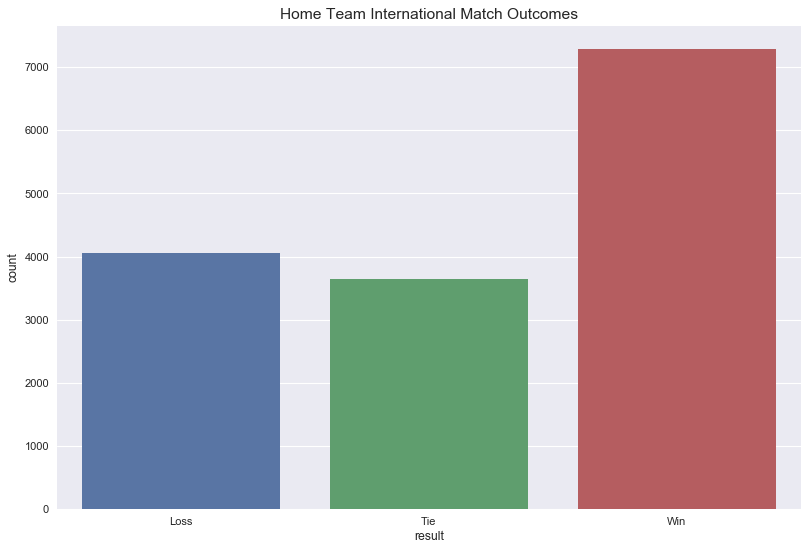

In [9]:
plt.figure(figsize=(12, 8), dpi= 80)
sns.set(style='darkgrid')
sns.countplot(x='result', data = results_df)
plt.xticks(range(3), ['Loss','Tie','Win'])
plt.title('Home Team International Match Outcomes', fontsize=14)
plt.show()

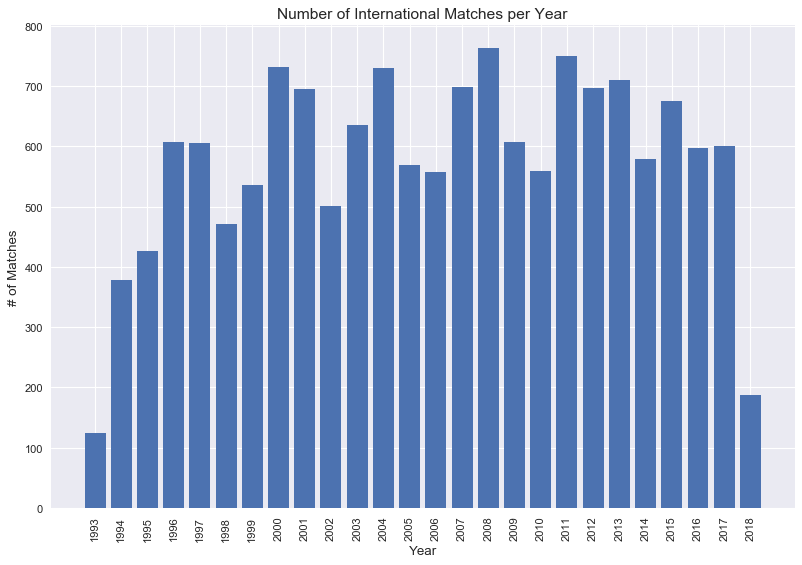

In [10]:
games_per_year = results_df.groupby(['year'])['year'].count()
years = ['1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003',
       '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014',
       '2015', '2016', '2017', '2018']
plt.figure(figsize=(12, 8), dpi= 80)
plt.bar(range(len(games_per_year)), games_per_year)
plt.xticks(range(len(games_per_year)), years, rotation = 90)
plt.title('Number of International Matches per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('# of Matches', fontsize=12)
plt.show()

In [11]:
results_df.describe()

,home_score,away_score,rank_home,total_points_home,previous_points_home,cur_year_avg_weighted_home,two_year_ago_weighted_home,three_year_ago_weighted_home,rank_away,total_points_away,...,IncomeGroup_High income: nonOECD_away,IncomeGroup_Low income_away,IncomeGroup_Lower middle income_away,IncomeGroup_Upper middle income_away,rank_difference,average_rank,score_difference,total_goals,year,result
count,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,...,14997.000000,14997.000000,14997.000000,14997.000000,14997.000000,14997.00000,14997.000000,14997.000000,14997.000000,14997.000000
mean,1.587584,1.048543,75.442622,153.037453,424.446556,77.112791,22.194996,15.363607,77.693539,147.574908,...,0.163099,0.142095,0.225712,0.276655,-2.250917,76.56808,0.539041,2.636127,2006.068814,0.608122
std,1.567929,1.220071,49.928677,300.513033,318.589583,157.394007,46.525233,32.006384,50.717812,291.576207,...,0.369469,0.349159,0.418064,0.447359,52.260068,43.00937,2.127197,1.835480,6.842428,0.421358
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-202.000000,1.50000,-17.000000,0.000000,1993.000000,0.000000
25%,0.000000,0.000000,34.000000,0.000000,150.000000,0.000000,0.000000,0.000000,36.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-35.000000,42.00000,-1.000000,1.000000,2000.000000,0.000000
50%,1.000000,1.000000,70.000000,0.000000,408.000000,0.000000,0.000000,0.000000,71.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-3.000000,72.50000,0.000000,2.000000,2006.000000,0.500000
75%,2.000000,2.000000,110.000000,193.950000,610.000000,83.550000,19.050000,14.170000,113.000000,178.090000,...,0.000000,0.000000,0.000000,1.000000,30.000000,105.50000,2.000000,4.000000,2012.000000,1.000000
max,31.000000,17.000000,209.000000,1770.060000,1887.000000,1126.040000,347.600000,231.730000,209.000000,1770.060000,...,1.000000,1.000000,1.000000,1.000000,202.000000,204.00000,31.000000,31.000000,2018.000000,1.000000


In [12]:
print('Total International Matches played by 2018 World Cup teams between 1993-2018: {}'.format(results_df['result'].count()))

Total International Matches played by 2018 World Cup teams between 1993-2018: 14997


# Naive Model based on FIFA Ranking Only

In [13]:
results_df['fifa_correct_withDraws'] = ((results_df.home_score >= results_df.away_score) & (results_df.rank_home > results_df.rank_away)) | ((results_df.away_score >= results_df.home_score) & (results_df.rank_away > results_df.rank_home))
results_df['fifa_correct'] = ((results_df.home_score > results_df.away_score) & (results_df.rank_home > results_df.rank_away)) | ((results_df.away_score > results_df.home_score) & (results_df.rank_away > results_df.rank_home))

print('Accuracy of FIFA Ranking at Predicting Winner: {}%'
      .format(round(results_df.fifa_correct.sum()/results_df.fifa_correct.count()*100, 2)))

Accuracy of FIFA Ranking at Predicting Winner: 21.88%


In [14]:
no_Draws_df = results_df.loc[results_df['result'] != 0.5].copy()
no_Draws_df['fifa_correct_withDraws'] = ((no_Draws_df.home_score >= no_Draws_df.away_score) & (no_Draws_df.rank_home > no_Draws_df.rank_away)) | ((no_Draws_df.away_score >= no_Draws_df.home_score) & (no_Draws_df.rank_away > no_Draws_df.rank_home))
no_Draws_df['fifa_correct'] = ((no_Draws_df.home_score > no_Draws_df.away_score) & (no_Draws_df.rank_home > no_Draws_df.rank_away)) | ((no_Draws_df.away_score > no_Draws_df.home_score) & (no_Draws_df.rank_away > no_Draws_df.rank_home))
no_Draws_df.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,rank_difference,average_rank,score_difference,is_stake,total_goals,year,winning_team,result,fifa_correct_withDraws,fifa_correct
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,37.0,40.5,2,True,4,1993,Bolivia,1.0,True,True
1,1997-06-18,Bolivia,Uruguay,1,0,Copa América,La Paz,Bolivia,False,1997-06-18,...,-17.0,42.5,1,True,1,1997,Bolivia,1.0,False,False
2,1997-07-20,Bolivia,Uruguay,1,0,FIFA World Cup qualification,La Paz,Bolivia,False,1997-07-20,...,-26.0,31.0,1,True,1,1997,Bolivia,1.0,False,False
4,2001-07-13,Bolivia,Uruguay,0,1,Copa América,Medellín,Colombia,True,2001-07-13,...,26.0,53.0,-1,True,1,2001,Uruguay,0.0,False,False
6,2007-06-30,Bolivia,Uruguay,0,1,Copa América,San Cristóbal,Venezuela,True,2007-06-30,...,62.0,61.0,-1,True,1,2007,Uruguay,0.0,False,False


In [15]:
print('Accuracy of FIFA Ranking at Predicting Winner (ignoring draws): {}%'
      .format(round(no_Draws_df.fifa_correct.sum()/no_Draws_df.fifa_correct.count()*100, 2)))

Accuracy of FIFA Ranking at Predicting Winner (ignoring draws): 28.9%


# Visualize Subset of the Data for Portugal Matches Only

In [16]:
# Let's work with a subset of the data that includes games played by Portugal
portugal = results_df[(results_df['home_team'] == 'Portugal') | (results_df['away_team'] == 'Portugal')]
portugal.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,rank_difference,average_rank,score_difference,is_stake,total_goals,year,winning_team,result,fifa_correct_withDraws,fifa_correct
263,2013-02-06,Portugal,Ecuador,2,3,Friendly,Guimarães,Portugal,False,2013-02-06,...,-5.0,9.5,-1,False,5,2013,Ecuador,0.0,True,True
633,2017-11-10,Portugal,Saudi Arabia,3,0,Friendly,Viseu,Portugal,False,2017-11-10,...,-60.0,33.0,3,False,3,2017,Portugal,1.0,False,False
800,2010-06-01,Portugal,Cameroon,3,1,Friendly,Covilhã,Portugal,False,2010-06-01,...,-16.0,11.0,2,False,4,2010,Portugal,1.0,False,False
801,2014-03-05,Portugal,Cameroon,5,1,Friendly,Leiria,Portugal,False,2014-03-05,...,-42.0,25.0,4,False,6,2014,Portugal,1.0,False,False
1081,1993-10-13,Portugal,Switzerland,1,0,FIFA World Cup qualification,Porto,Portugal,False,1993-10-13,...,11.0,15.5,1,True,1,1993,Portugal,1.0,True,True


C:\Users\Bruno\Anaconda3\lib\site-packages\seaborn\categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


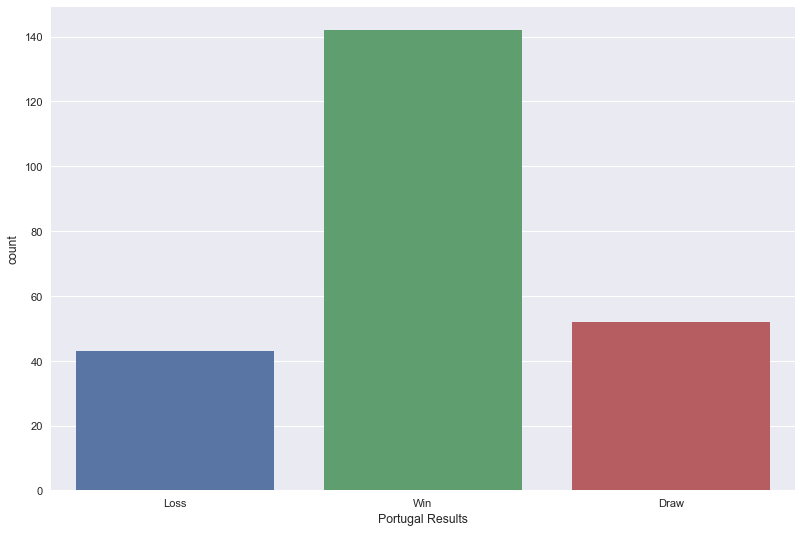

In [17]:
# Visualize Portugal game outcomes
wins = []
for row in portugal['winning_team']:
    if row != 'Portugal' and row != 'Draw':
        wins.append('Loss')
    elif row == 'Draw':
        wins.append('Draw')
    else:
        wins.append('Win')
        
winsdf= pd.DataFrame(wins, columns=['Portugal Results'])

plt.figure(figsize=(12, 8), dpi= 80)
sns.set(style='darkgrid')
sns.countplot(x='Portugal Results', data=winsdf)

# Evaluate Baseline Decision Tree Model

In [95]:
no_draw_train_df = results_df[results_df['result'] != 0.5]

# remove features without predictive value or not known prior to game start
train_df = no_draw_train_df[['rank_home','rank_away','neutral','previous_points_home','cur_year_avg_weighted_home',
                     'two_year_ago_weighted_home','three_year_ago_weighted_home','previous_points_away',
                     'cur_year_avg_weighted_away','two_year_ago_weighted_away','three_year_ago_weighted_away',
                     'rank_difference','average_rank','is_stake','result']]

In [96]:
# split training set in features/labels
features = train_df.drop(['result'], axis = 1)
labels = np.asarray(train_df['result'], dtype="|S6")

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, 
                                                                            random_state = 42)

# Show the number of observations for the test and training dataframes
print('Number of observations in the training data:', len(train_labels))
print('Number of observations in the test data:',len(test_labels))

Number of observations in the training data: 8513
Number of observations in the test data: 2838


The optimal tree depth is: 5


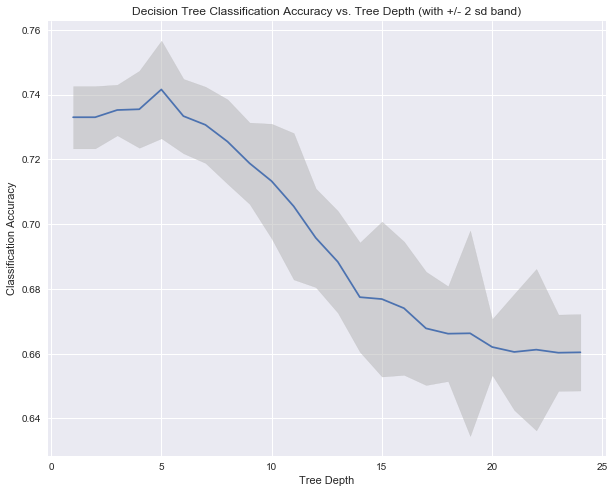

In [97]:
tree_depth = list(range(1,25))

cv_scores_mean = []
cv_scores_std = []
for depth in tree_depth:
    baselineModel = DecisionTreeClassifier(max_depth=depth)
    scores = cross_val_score(baselineModel, train_features, train_labels, cv=5, scoring='accuracy')
    cv_scores_mean.append(scores.mean())
    cv_scores_std.append(scores.std())
    
# determining best tree depth
optimal_depth = tree_depth[cv_scores_mean.index(max(cv_scores_mean))]
print('The optimal tree depth is: {}'.format(optimal_depth))

# plot classification accuracy vs tree depth
plt.rcParams['figure.figsize'] = (10,8)
plt.plot(tree_depth, cv_scores_mean)
plt.fill_between(tree_depth, (np.array(cv_scores_mean) - 2*np.array(cv_scores_std)), 
                 (np.array(cv_scores_mean) + 2*np.array(cv_scores_std)), color = [0.7, 0.7, 0.7], alpha = 0.5)
plt.title('Decision Tree Classification Accuracy vs. Tree Depth (with +/- 2 sd band)')
plt.xlabel('Tree Depth')
plt.ylabel('Classification Accuracy')
plt.show()

In [98]:
baselineModel = DecisionTreeClassifier(max_depth=optimal_depth).fit(train_features, train_labels)

print('Decision Tree Classifier (FIFA rank only):')
print('Classification Accuracy on training set: {}%'.format(round(baselineModel.score(train_features, train_labels,)*100, 2)))
print('Classification Accuracy on testing set: {}%\n'.format(round(baselineModel.score(test_features, test_labels,)*100, 2)))

Decision Tree Classifier (FIFA rank only):
Classification Accuracy on training set: 75.17%
Classification Accuracy on testing set: 74.21%



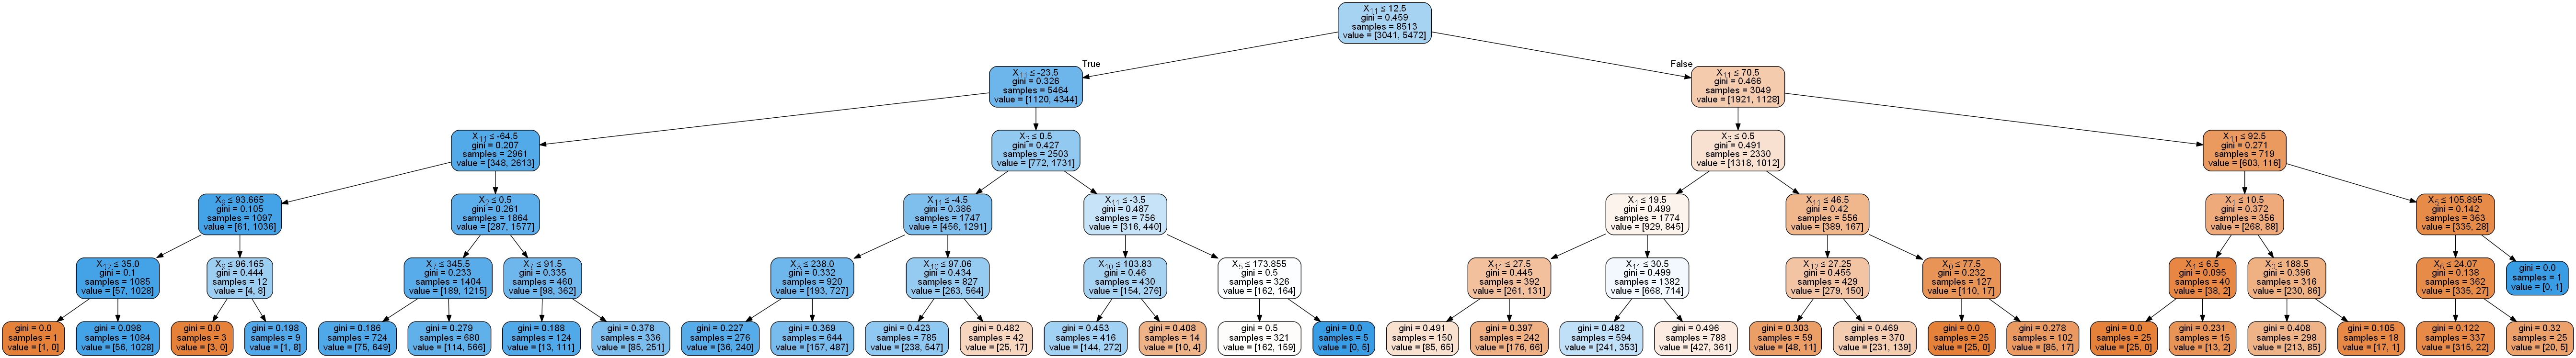

In [99]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os
import sys

# Fix pydotplus error that it can't find Graphviz executables from:
# https://stackoverflow.com/questions/42235431/ipython-3-5-graphvizs-executables-not-found-after-installing-graphviz-and-pydot
def conda_fix(graph):
    path = os.path.join(sys.base_exec_prefix, "Library", "bin", "graphviz")
    paths = ("dot", "twopi", "neato", "circo", "fdp")
    paths = {p: os.path.join(path, "{}.exe".format(p)) for p in paths}
    graph.set_graphviz_executables(paths)

dot_data = StringIO()
export_graphviz(baselineModel, out_file=dot_data, filled=True, rounded=True, special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
conda_fix(graph)

# View the decision tree for baseline model
Image(graph.create_png())

In [118]:
graph.write_png('output.png')

save(graph.create_png(), 'baselineTree.png')

''baselineTree.png')' was not found in history, as a file, url, nor in the user namespace.


# Part 2: Develop Model with Elo Rating

The Elo rating system is a method for calculating the relative skill levels of teams (or players) in zero-sum games. From Wikipedia, a team's Elo rating as applied to our data set is represented by a number which increases or decreases depending on the outcome of matches between international teams. After every game, the winning team takes points from the losing one. The difference between the ratings of the winner and loser determines the total number of points gained or lost after a game. In a series of games between a high-rated team and a low-rated team, the high-rated team is expected to score more wins. If the high-rated team wins, then only a few rating points will be taken from the low-rated team. However, if the lower rated team scores an upset win, many rating points will be transferred. The lower rated team will also gain a few points from the higher rated team in the event of a draw. This means that this rating system is self-correcting. A team whose rating is too low should, in the long run, do better than the rating system predicts, and thus gain rating points until the rating reflects their true playing strength. The elo function that we used resembles the Elo World Ranking which is defined in the images below.


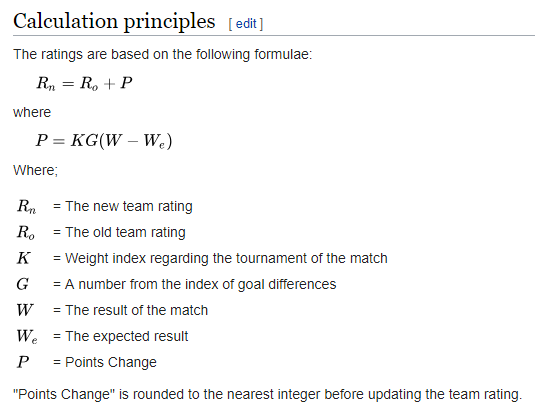

In [23]:
from IPython.display import Image
Image(filename='EloCalculation.png') 

Our Elo ranking system puts the most weight on world cup matches K = 60, the least weight on friendly matches K = 20, and all other matches such as regional tournaments/olympic games/etc. use a gain of K = 40.

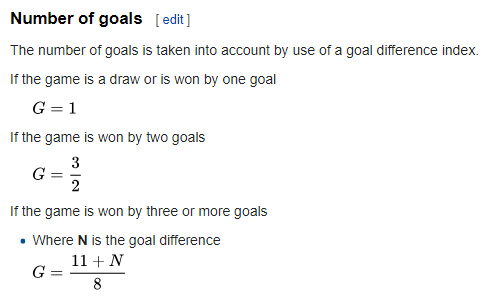

In [24]:
Image(filename='EloGoals.png') 

In [25]:
# prepare dataframes for Elo Rankings
elo_games_df = results_df[['date','home_team','away_team','home_score','away_score','tournament','result']].reset_index()
elo_games_df['home_elo_before_game'] = 0
elo_games_df['home_elo_after_game'] = 0
elo_games_df['away_elo_before_game'] = 0
elo_games_df['away_elo_after_game'] = 0
elo_games_df.head()

,index,date,home_team,away_team,home_score,away_score,tournament,result,home_elo_before_game,home_elo_after_game,away_elo_before_game,away_elo_after_game
0,0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,1.0,0,0,0,0
1,1,1997-06-18,Bolivia,Uruguay,1,0,Copa América,1.0,0,0,0,0
2,2,1997-07-20,Bolivia,Uruguay,1,0,FIFA World Cup qualification,1.0,0,0,0,0
3,3,2000-11-15,Bolivia,Uruguay,0,0,FIFA World Cup qualification,0.5,0,0,0,0
4,4,2001-07-13,Bolivia,Uruguay,0,1,Copa América,0.0,0,0,0,0


Each team begins with a base elo score of 1500 for their first match and it gets updated after each successive match.

In [26]:
teams = pd.unique(elo_games_df[['home_team', 'away_team']].values.ravel('K'))
elo_teams_df = pd.DataFrame({'team': teams, 'elo': 1500})
elo_teams_df.head()

,elo,team
0,1500,Bolivia
1,1500,Brazil
2,1500,Ecuador
3,1500,Paraguay
4,1500,Peru


### Compute Elo Ratings

In [27]:
# Set some constants
mean_elo = 1500
elo_width = 400

In [28]:
def update_elo(home_elo, away_elo, match_result, match_type, home_score, away_score):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    if(match_type == 'FIFA World Cup'):
        k_factor = 60.0
    elif(match_type == 'Friendly'):
        k_factor = 20.0
    else:
        k_factor = 40.0    
    
    if(home_score == away_score):
        goal_factor = 1.0
    elif(np.abs(home_score - away_score) == 2):
        goal_factor = 1.5
    else:
        goal_factor = (11 + np.abs(home_score - away_score))/8        
    
    expected_win = expected_result(home_elo, away_elo)
    change_in_elo = k_factor * goal_factor * (match_result - expected_win)
    home_elo += change_in_elo
    away_elo -= change_in_elo
    
    return home_elo, away_elo

def expected_result(elo_a, elo_b):
    """
    https://en.wikipedia.org/wiki/Elo_rating_system#Mathematical_details
    """
    expect_a = 1.0/(1+10**((elo_b - elo_a)/elo_width))
    return expect_a

#### The loop where it happens
- We go through each row in the DataFrame.
- We look up the current Elo rating of both teams.
- We calculate the expected wins for the team that actually won.
- Write Elo before and after the game in the Data Frame.
- Update the Elo rating for both teams in the "current_elos" list.

In [29]:
current_season = elo_games_df.date[:0].dt.year
for row in elo_games_df.itertuples():
       
    idx = row.Index
    home_team = row.home_team
    away_team = row.away_team
  
    # Get pre-match ratings
    teamA_elo = elo_teams_df.loc[elo_teams_df['team'] == home_team, 'elo'].values[0]
    teamB_elo = elo_teams_df.loc[elo_teams_df['team'] == away_team, 'elo'].values[0]

    # Update on game results
    home_elo_after, away_elo_after = update_elo(teamA_elo, teamB_elo, row.result, row.tournament, 
                                                row.home_score, row.away_score)
        
    # Save updated elos
    elo_games_df.at[idx, 'home_elo_before_game'] = teamA_elo
    elo_games_df.at[idx, 'away_elo_before_game'] = teamB_elo
    elo_games_df.at[idx, 'home_elo_after_game'] = home_elo_after
    elo_games_df.at[idx, 'away_elo_after_game'] = away_elo_after
    
    # update current elos
    elo_teams_df.set_value(elo_teams_df.loc[elo_teams_df.team == home_team].index.values[0], 'elo', home_elo_after)
    elo_teams_df.set_value(elo_teams_df.loc[elo_teams_df.team == away_team].index.values[0], 'elo', away_elo_after)

elo_games_df.head()

C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


,index,date,home_team,away_team,home_score,away_score,tournament,result,home_elo_before_game,home_elo_after_game,away_elo_before_game,away_elo_after_game
0,0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,1.0,1500,1530,1500,1470
1,1,1997-06-18,Bolivia,Uruguay,1,0,Copa América,1.0,1530,1554,1470,1445
2,2,1997-07-20,Bolivia,Uruguay,1,0,FIFA World Cup qualification,1.0,1554,1574,1445,1424
3,3,2000-11-15,Bolivia,Uruguay,0,0,FIFA World Cup qualification,0.5,1574,1565,1424,1432
4,4,2001-07-13,Bolivia,Uruguay,0,1,Copa América,0.0,1565,1524,1432,1472


In [30]:
elo_teams_df.sort_values(['elo'], ascending=False).head(10)

,elo,team
1,1855,Brazil
20,1835,Germany
5,1832,Australia
21,1831,Italy
11,1827,Spain
51,1812,Netherlands
7,1787,Argentina
14,1787,Saudi Arabia
13,1774,Morocco
17,1761,Tunisia


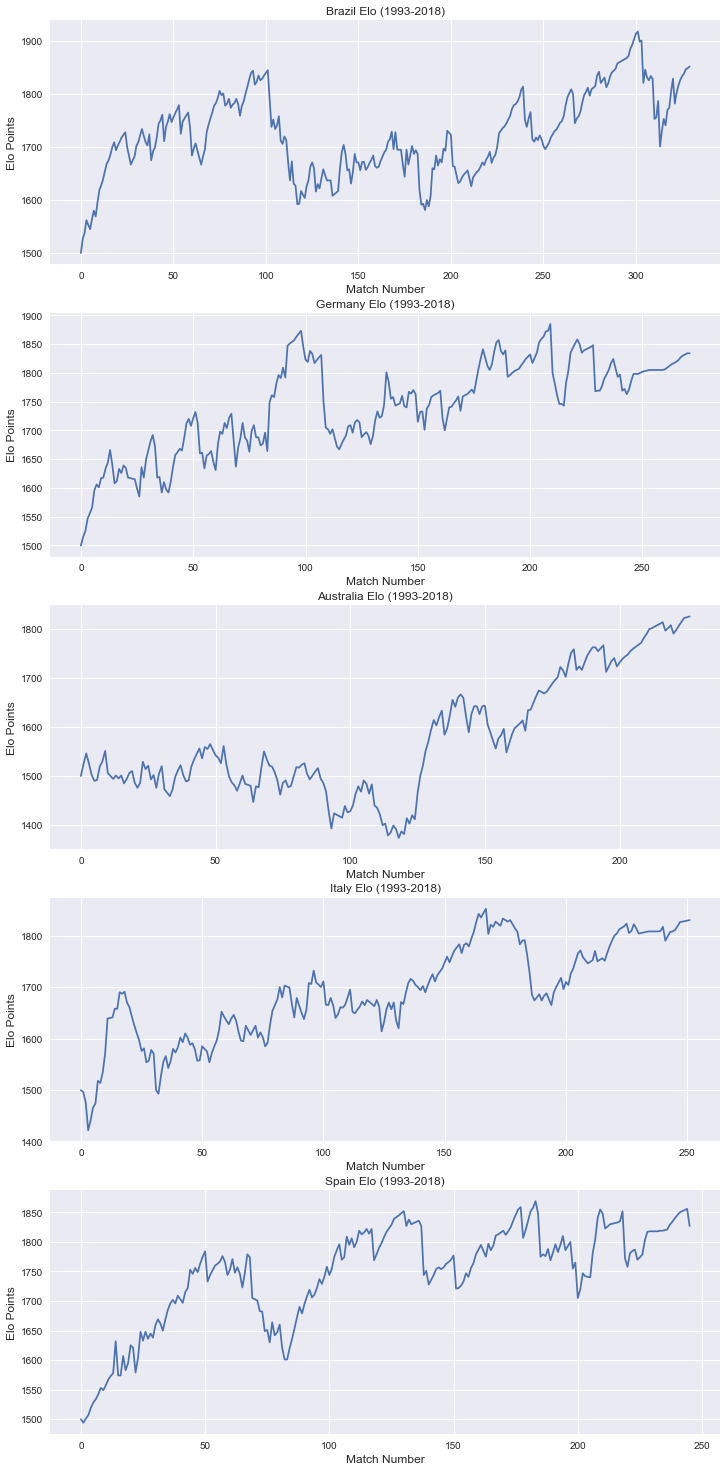

In [31]:
# capture top 5 teams and plot elo change with time for each team
elo_top5 = elo_teams_df.sort_values(['elo'], ascending=False).head(5)['team'].values.tolist()

fig, axs = plt.subplots(5,1, figsize=(12, 26), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, team in enumerate(elo_top5):
    team_df = elo_games_df[(elo_games_df['home_team'] == team) | (elo_games_df['away_team'] == team)] 
    
    elo_over_time = []
    for row in team_df.itertuples():
        if(row.home_team == team):
            elo_over_time.append(row.home_elo_before_game)
        else:
            elo_over_time.append(row.away_elo_before_game)

    axs[i].plot(elo_over_time)
    axs[i].set_ylabel('Elo Points', fontsize=12)
    axs[i].set_title('{} Elo (1993-2018)'.format(team))
    axs[i].set_xlabel('Match Number', fontsize=12) 

plt.show()

In [32]:
results_df['index'] = range(len(results_df))

# join Elo scores with world cup team games dataset
train_results_df = results_df.merge(elo_games_df, 
                        left_on='index', 
                        right_on='index')

train_results_df.head()

,date_x,home_team_x,away_team_x,home_score_x,away_score_x,tournament_x,city,country,neutral,rank_date_home,...,home_team_y,away_team_y,home_score_y,away_score_y,tournament_y,result_y,home_elo_before_game,home_elo_after_game,away_elo_before_game,away_elo_after_game
0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,La Paz,Bolivia,False,1993-08-08,...,Bolivia,Uruguay,3,1,FIFA World Cup qualification,1.0,1500,1530,1500,1470
1,1997-06-18,Bolivia,Uruguay,1,0,Copa América,La Paz,Bolivia,False,1997-06-18,...,Bolivia,Uruguay,1,0,Copa América,1.0,1530,1554,1470,1445
2,1997-07-20,Bolivia,Uruguay,1,0,FIFA World Cup qualification,La Paz,Bolivia,False,1997-07-20,...,Bolivia,Uruguay,1,0,FIFA World Cup qualification,1.0,1554,1574,1445,1424
3,2000-11-15,Bolivia,Uruguay,0,0,FIFA World Cup qualification,La Paz,Bolivia,False,2000-11-15,...,Bolivia,Uruguay,0,0,FIFA World Cup qualification,0.5,1574,1565,1424,1432
4,2001-07-13,Bolivia,Uruguay,0,1,Copa América,Medellín,Colombia,True,2001-07-13,...,Bolivia,Uruguay,0,1,Copa América,0.0,1565,1524,1432,1472


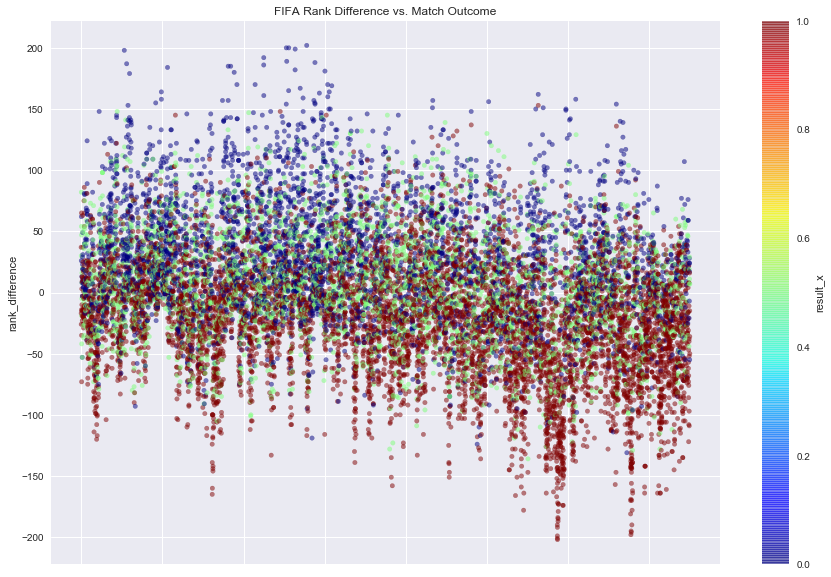

In [33]:
plt.rcParams['figure.figsize'] = (15,10)
train_results_df.plot.scatter('index','rank_difference', c='result_x', colormap='jet', alpha=0.5,
                             title = 'FIFA Rank Difference vs. Match Outcome')
plt.show()

In [34]:
train_results_df['fifa_upsets'] = ((train_results_df.home_score_x > train_results_df.away_score_x) & \
                              (train_results_df.rank_home < train_results_df.rank_away)) | \
                              ((train_results_df.away_score_x > train_results_df.home_score_x) & \
                               (train_results_df.rank_away < train_results_df.rank_home))
    
train_results_df['elo_upsets'] = ((train_results_df.home_score_x > train_results_df.away_score_x) & \
                              (train_results_df.home_elo_before_game < train_results_df.away_elo_before_game)) | \
                              ((train_results_df.away_score_x > train_results_df.home_score_x) & \
                               (train_results_df.away_elo_before_game < train_results_df.home_elo_before_game))
        
print('Number of Upsets based on FIFA Rank: {}%'
      .format(round(train_results_df.fifa_upsets.sum()/train_results_df.fifa_upsets.count()*100, 1)))

print('Number of Upsets based on Elo Score: {}%'
      .format(round(train_results_df.elo_upsets.sum()/train_results_df.elo_upsets.count()*100, 1)))

Number of Upsets based on FIFA Rank: 53.7%
Number of Upsets based on Elo Score: 20.3%


In [35]:
list(train_results_df)

['date_x',
 'home_team_x',
 'away_team_x',
 'home_score_x',
 'away_score_x',
 'tournament_x',
 'city',
 'country',
 'neutral',
 'rank_date_home',
 'rank_home',
 'country_full_home',
 'country_abrv_home',
 'total_points_home',
 'previous_points_home',
 'cur_year_avg_weighted_home',
 'two_year_ago_weighted_home',
 'three_year_ago_weighted_home',
 'rank_date_away',
 'rank_away',
 'country_full_away',
 'country_abrv_away',
 'total_points_away',
 'previous_points_away',
 'cur_year_avg_weighted_away',
 'two_year_ago_weighted_away',
 'three_year_ago_weighted_away',
 'ShortName_home',
 'Region_Europe & Central Asia_home',
 'Region_Latin America & Caribbean_home',
 'Region_Middle East & North Africa_home',
 'Region_North America_home',
 'Region_South Asia_home',
 'Region_Sub-Saharan Africa_home',
 'IncomeGroup_High income: nonOECD_home',
 'IncomeGroup_Low income_home',
 'IncomeGroup_Lower middle income_home',
 'IncomeGroup_Upper middle income_home',
 'ShortName_away',
 'Region_Europe & Central 

In [106]:
# generate additional features
train_results_df['elo_difference'] = train_results_df['home_elo_before_game'] - train_results_df['away_elo_before_game']
train_results_df['average_elo'] = (train_results_df['home_elo_before_game'] + train_results_df['away_elo_before_game'])/2

no_draw_train_df = train_results_df[train_results_df['result_x'] != 0.5]

# remove features without predictive value or not known prior to game start
train_elo_df = no_draw_train_df[['neutral','home_elo_before_game','away_elo_before_game','is_stake','elo_difference',
                                 'average_elo','Region_Europe & Central Asia_home','Region_Latin America & Caribbean_home',
                                 'Region_Middle East & North Africa_home','Region_North America_home','Region_South Asia_home',
                                 'Region_Sub-Saharan Africa_home','IncomeGroup_High income: nonOECD_home',
                                 'IncomeGroup_Low income_home','IncomeGroup_Lower middle income_home',
                                 'IncomeGroup_Upper middle income_home','Region_Europe & Central Asia_away',
                                 'Region_Latin America & Caribbean_away','Region_Middle East & North Africa_away',
                                 'Region_North America_away','Region_South Asia_away','Region_Sub-Saharan Africa_away',
                                 'IncomeGroup_High income: nonOECD_away','IncomeGroup_Low income_away',
                                 'IncomeGroup_Lower middle income_away','IncomeGroup_Upper middle income_away','result_x']]

In [107]:
# split training set in features/labels
features = train_elo_df.drop(['result_x'], axis = 1)
labels = np.asarray(train_elo_df['result_x'], dtype="|S6")

features.head()

,neutral,home_elo_before_game,away_elo_before_game,is_stake,elo_difference,average_elo,Region_Europe & Central Asia_home,Region_Latin America & Caribbean_home,Region_Middle East & North Africa_home,Region_North America_home,...,Region_Europe & Central Asia_away,Region_Latin America & Caribbean_away,Region_Middle East & North Africa_away,Region_North America_away,Region_South Asia_away,Region_Sub-Saharan Africa_away,IncomeGroup_High income: nonOECD_away,IncomeGroup_Low income_away,IncomeGroup_Lower middle income_away,IncomeGroup_Upper middle income_away
0,False,1500,1500,True,0,1500.0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
1,False,1530,1470,True,60,1500.0,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
2,False,1554,1445,True,109,1499.5,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
4,True,1565,1432,True,133,1498.5,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0
6,True,1521,1474,True,47,1497.5,0,1,0,0,...,0,1,0,0,0,0,1,0,0,0


In [108]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, 
                                                                            random_state = 42)

In [109]:
baselineModel = DecisionTreeClassifier(max_depth=5).fit(train_features, train_labels)

print('Decision Tree Classifier:')
print('Classification Accuracy on training set: {}%'.format(round(baselineModel.score(train_features, train_labels,)*100, 2)))
print('Classification Accuracy on testing set: {}%\n'.format(round(baselineModel.score(test_features, test_labels,)*100, 2)))

Decision Tree Classifier:
Classification Accuracy on training set: 74.12%
Classification Accuracy on testing set: 72.69%



# Part 3: Ensemble Learners

The optimal combination of features from parts 1 and 2 (may include FIFA rank, Elo score, or both) will be used to train a variety of classification models (Random Forest, xgboost, LDA, QDA, KNN, etc.). The probabilistic results for each match (win, tie, loss) will be blended with the results of a Poisson Distribution model that uses the complete player ranking data scraped from sofifa.com for the FIFA 2018 video game to predict the group stages of the 2018 FIFA World Cup. The knockout stages of the world cup will be simulated 1000 times to determine the probability of each team winning the tournament. Matches that result in a tie during the knockout stages will take into account the average penalty rating of the top 5 penalty shooters for each time from the sofifa.com data set to break the tie. The final result will be the probability of each of the 32 teams that qualified for the 2018 World Cup to win the tournament.

In [110]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 500 decision trees
rf = RandomForestClassifier(n_estimators = 500, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

In [111]:
# Use the forest predict method on the test data
predictions = rf.predict(test_features)

# View the predicted probabilities of the first 10 observations
rf.predict_proba(test_features)[0:10]

array([[ 0.076,  0.924],
       [ 0.162,  0.838],
       [ 0.744,  0.256],
       [ 0.396,  0.604],
       [ 0.134,  0.866],
       [ 0.422,  0.578],
       [ 0.01 ,  0.99 ],
       [ 0.224,  0.776],
       [ 0.288,  0.712],
       [ 0.006,  0.994]])

In [112]:
predictions[0:10]

array([b'1.0', b'1.0', b'0.0', b'1.0', b'1.0', b'1.0', b'1.0', b'1.0',
       b'1.0', b'1.0'], 
      dtype='|S6')

In [113]:
# Create confusion matrix
pd.crosstab(test_labels, predictions, rownames=['Actual Outcome'], colnames=['Predicted Outcome']).apply(lambda r: r/r.sum(), axis=1)

Predicted Outcome,b'0.0',b'1.0'
Actual Outcome,,
b'0.0',0.531096,0.468904
b'1.0',0.166027,0.833973


In [114]:
from sklearn.metrics import accuracy_score

# Test Accuracy
print('Test Accuracy: {}'.format(accuracy_score(test_labels, predictions)))

Test Accuracy: 0.7258632840028189


In [115]:
# get feature names
feature_list = list(features.columns)

# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:30} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: elo_difference                 Importance: 0.26
Variable: away_elo_before_game           Importance: 0.19
Variable: home_elo_before_game           Importance: 0.18
Variable: average_elo                    Importance: 0.16
Variable: neutral                        Importance: 0.02
Variable: is_stake                       Importance: 0.02
Variable: IncomeGroup_Upper middle income_home Importance: 0.02
Variable: IncomeGroup_Upper middle income_away Importance: 0.02
Variable: Region_Europe & Central Asia_home Importance: 0.01
Variable: Region_Latin America & Caribbean_home Importance: 0.01
Variable: Region_Middle East & North Africa_home Importance: 0.01
Variable: Region_Sub-Saharan Africa_home Importance: 0.01
Variable: IncomeGroup_High income: nonOECD_home Importance: 0.01
Variable: IncomeGroup_Low income_home    Importance: 0.01
Variable: IncomeGroup_Lower middle income_home Importance: 0.01
Variable: Region_Europe & Central Asia_away Importance: 0.01
Variable: Region_Latin Ame

In [116]:
from sklearn.decomposition import PCA

pca_5_transformer = PCA(5).fit(train_features)
np.cumsum(pca_5_transformer.explained_variance_ratio_)

array([ 0.56661497,  0.99997483,  0.99997933,  0.99998319,  0.99998541])

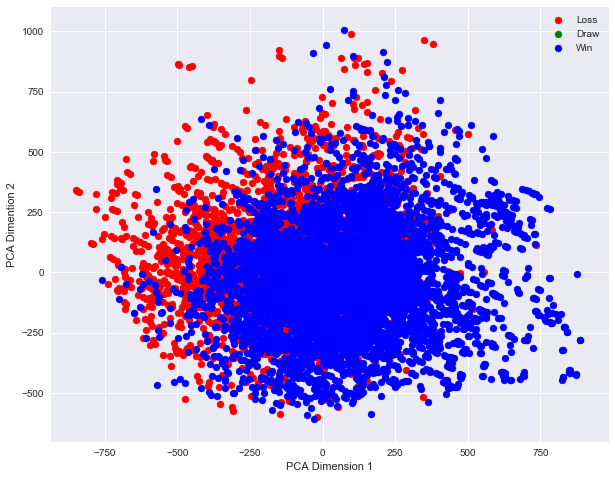

In [117]:
pca_transformer = PCA(2).fit(train_features)
x_train_2d = pca_transformer.transform(train_features)
x_test_2d = pca_transformer.transform(test_features)

# lists to track each group's plotting color and label
colors = ['r', 'g', 'b']
label_text = ['Loss', 'Draw', 'Win']

plt.rcParams['figure.figsize'] = (10,8)

# loop over the different groups
for result in [0.0,0.5,1]:
    result_df = x_train_2d[train_labels.astype(np.float) == result]
    plt.scatter(result_df[:,0], result_df[:,1], c = colors[int(2*result)], label=label_text[int(2*result)])
    
# add labels
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimention 2")
plt.legend()
plt.show()

The optimal number of neighbors is: 39


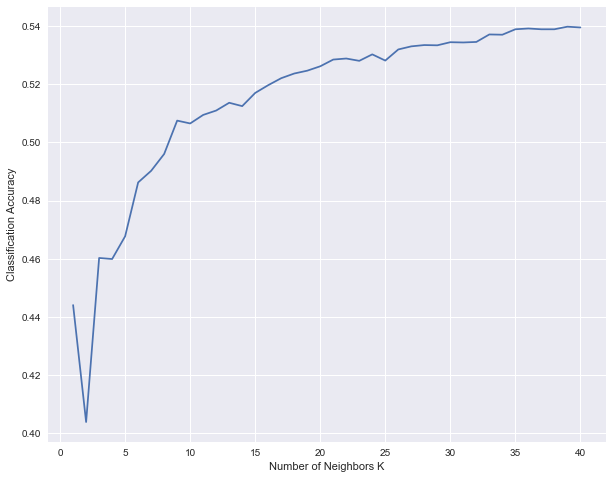

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

neighbors = list(range(1,41))
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_features, train_labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# determining best k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print('The optimal number of neighbors is: {}'.format(optimal_k))

# plot classification accuracy vs k
plt.plot(neighbors, cv_scores)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Classification Accuracy')
plt.show()

The optimal max depth for XGB model is: 2


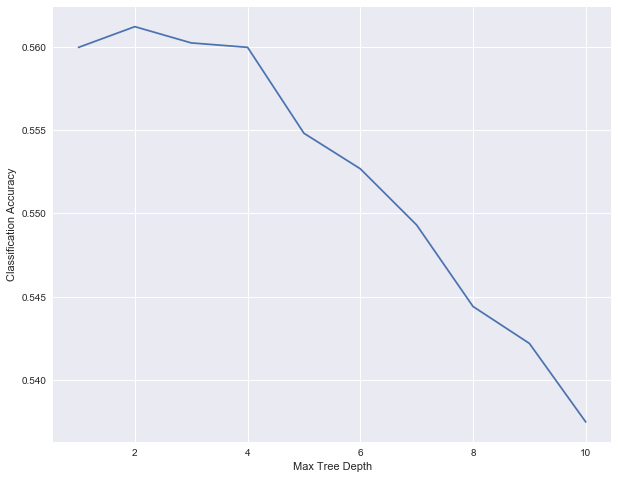

In [50]:
from xgboost import XGBClassifier

depth = list(range(1,11))
cv_scores = []
for d in depth:
    xgb = XGBClassifier(max_depth=d)
    scores = cross_val_score(xgb, train_features, train_labels, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
    
# determining best depth
optimal_depth = depth[cv_scores.index(max(cv_scores))]
print('The optimal max depth for XGB model is: {}'.format(optimal_depth))

# plot classification accuracy vs depth
plt.plot(depth, cv_scores)
plt.xlabel('Max Tree Depth')
plt.ylabel('Classification Accuracy')
plt.show()

In [59]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

lda = LinearDiscriminantAnalysis().fit(x_train_2d, train_labels)
qda = QuadraticDiscriminantAnalysis().fit(x_train_2d, train_labels)
knn = KNeighborsClassifier(n_neighbors=optimal_k).fit(x_train_2d, train_labels)
xgb = XGBClassifier(max_depth=optimal_depth).fit(x_train_2d, train_labels)

print('LDA Test Accuracy: {}%'.format(round(lda.score(x_test_2d, test_labels)*100,2)))
print('QDA Test Accuracy: {}%'.format(round(qda.score(x_test_2d, test_labels)*100,2)))
print('KNN Test Accuracy: {}%'.format(round(knn.score(x_test_2d, test_labels)*100,2)))
print('XGB Test Accuracy: {}%'.format(round(xgb.score(x_test_2d, test_labels)*100,2)))

LDA Test Accuracy: 55.25%
QDA Test Accuracy: 55.31%
KNN Test Accuracy: 53.92%
XGB Test Accuracy: 55.55%


In [60]:
model_names = ['lda', 'qda', 'knn', 'xgb']
models = [lda, qda, knn, xgb]

ensemble_tune = []
ensemble_test = []

for i in models:
    ensemble_tune.append(i.predict(x_train_2d))
    ensemble_test.append(i.predict(x_test_2d))

ensemble_tune = np.array(ensemble_tune).reshape(4, len(x_train_2d)).T
ensemble_test = np.array(ensemble_test).reshape(4, len(x_test_2d)).T

# Convert ensemble tune/test to dataframes to concatenate
ensemble_tune_df = pd.DataFrame(np.vstack(ensemble_tune), columns = model_names)
ensemble_test_df = pd.DataFrame(np.vstack(ensemble_test), columns = model_names)
x_tune = pd.DataFrame(x_train_2d, columns = ['PCA1', 'PCA2'])
x_test = pd.DataFrame(x_test_2d, columns = ['PCA1', 'PCA2'])

# Concatenate x_tune/x_test with ensemble_tune/test
augmented_tune = pd.concat([x_tune, ensemble_tune_df], axis=1, join_axes=[x_tune.index])
augmented_test = pd.concat([x_test, ensemble_test_df], axis=1, join_axes=[x_test.index])

augmentedModel_dt = DecisionTreeClassifier(max_depth=4).fit(augmented_tune, train_labels)

print('Augmented Decision Meta-Tree Classifier:')
print('Classification Accuracy on test set: {}%\n'.format(round(augmentedModel_dt.score(augmented_test, test_labels)*100, 2)))

Augmented Decision Meta-Tree Classifier:
Classification Accuracy on test set: 54.05%



In [61]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

lda = LinearDiscriminantAnalysis().fit(train_features, train_labels)
qda = QuadraticDiscriminantAnalysis().fit(train_features, train_labels)
knn = KNeighborsClassifier(n_neighbors=23).fit(train_features, train_labels)
xgb = XGBClassifier(max_depth=2).fit(train_features, train_labels)

print('LDA Test Accuracy: {}%'.format(round(lda.score(test_features, test_labels)*100,2)))
print('QDA Test Accuracy: {}%'.format(round(qda.score(test_features, test_labels)*100,2)))
print('KNN Test Accuracy: {}%'.format(round(knn.score(test_features, test_labels)*100,2)))
print('XGB Test Accuracy: {}%'.format(round(xgb.score(test_features, test_labels)*100,2)))

C:\Users\Bruno\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Bruno\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


LDA Test Accuracy: 55.44%
QDA Test Accuracy: 47.89%
KNN Test Accuracy: 53.63%
XGB Test Accuracy: 55.04%


In [62]:
model_names = ['lda', 'knn', 'xgb']
models = [lda, knn, xgb]

ensemble_tune = []
ensemble_test = []

for i in models:
    ensemble_tune.append(i.predict(train_features))
    ensemble_test.append(i.predict(test_features))

ensemble_tune = np.array(ensemble_tune).reshape(len(models), len(train_features)).T
ensemble_test = np.array(ensemble_test).reshape(len(models), len(test_features)).T

# Convert ensemble tune/test to dataframes to concatenate
ensemble_tune_df = pd.DataFrame(np.vstack(ensemble_tune), columns = model_names)
ensemble_test_df = pd.DataFrame(np.vstack(ensemble_test), columns = model_names)

# Concatenate x_tune/x_test with ensemble_tune/test
train_features = train_features.reset_index(drop = True)
test_features = test_features.reset_index(drop = True)

augmented_tune = pd.concat([train_features, ensemble_tune_df], axis=1, join_axes=[train_features.index])
augmented_test = pd.concat([test_features, ensemble_test_df], axis=1, join_axes=[test_features.index])

augmentedModel_dt = DecisionTreeClassifier(max_depth=4).fit(augmented_tune, train_labels)

print('Augmented Decision Meta-Tree Classifier:')
print('Classification Accuracy on test set: {}%\n'.format(round(augmentedModel_dt.score(augmented_test, test_labels)*100, 2)))

Augmented Decision Meta-Tree Classifier:
Classification Accuracy on test set: 53.73%



# Predicting the 2018 World Cup

In [55]:
elo_games_df.head()

,index,date,home_team,away_team,home_score,away_score,tournament,result,home_elo_before_game,home_elo_after_game,away_elo_before_game,away_elo_after_game
0,0,1993-08-08,Bolivia,Uruguay,3,1,FIFA World Cup qualification,1.0,1500,1530,1500,1470
1,1,1997-06-18,Bolivia,Uruguay,1,0,Copa América,1.0,1530,1554,1470,1445
2,2,1997-07-20,Bolivia,Uruguay,1,0,FIFA World Cup qualification,1.0,1554,1574,1445,1424
3,3,2000-11-15,Bolivia,Uruguay,0,0,FIFA World Cup qualification,0.5,1574,1565,1424,1432
4,4,2001-07-13,Bolivia,Uruguay,0,1,Copa América,0.0,1565,1524,1432,1472


In [56]:
wc2018_df = pd.read_csv('2018WorldCupGroupSchedule-withResults.csv')
wc2018_df['Date'] = pd.to_datetime(wc2018_df['Date'])
wc2018_df.head()

,Date,home_team,away_team,Group,home_score,away_score,result,tournament,neutral,is_stake
0,2018-06-14,Russia,Saudi Arabia,Group A,5,0,1.0,FIFA World Cup,0,1
1,2018-06-15,Egypt,Uruguay,Group A,0,1,0.0,FIFA World Cup,1,1
2,2018-06-15,Morocco,Iran,Group B,0,1,0.0,FIFA World Cup,1,1
3,2018-06-15,Portugal,Spain,Group B,3,3,0.5,FIFA World Cup,1,1
4,2018-06-16,France,Australia,Group C,2,1,1.0,FIFA World Cup,1,1


In [57]:
# prepare dataframes for Elo Rankings
wc2018_elo_df = wc2018_df[['Date','home_team','away_team','home_score','away_score','tournament','result']].reset_index()
wc2018_elo_df['home_elo_before_game'] = 0
wc2018_elo_df['home_elo_after_game'] = 0
wc2018_elo_df['away_elo_before_game'] = 0
wc2018_elo_df['away_elo_after_game'] = 0
wc2018_elo_df.head()

,index,Date,home_team,away_team,home_score,away_score,tournament,result,home_elo_before_game,home_elo_after_game,away_elo_before_game,away_elo_after_game
0,0,2018-06-14,Russia,Saudi Arabia,5,0,FIFA World Cup,1.0,0,0,0,0
1,1,2018-06-15,Egypt,Uruguay,0,1,FIFA World Cup,0.0,0,0,0,0
2,2,2018-06-15,Morocco,Iran,0,1,FIFA World Cup,0.0,0,0,0,0
3,3,2018-06-15,Portugal,Spain,3,3,FIFA World Cup,0.5,0,0,0,0
4,4,2018-06-16,France,Australia,2,1,FIFA World Cup,1.0,0,0,0,0


In [58]:
for row in wc2018_elo_df.itertuples():
       
    idx = row.Index
    home_team = row.home_team
    away_team = row.away_team
  
    # Get pre-match ratings
    teamA_elo = elo_teams_df.loc[elo_teams_df['team'] == home_team, 'elo'].values[0]
    teamB_elo = elo_teams_df.loc[elo_teams_df['team'] == away_team, 'elo'].values[0]

    # Update on game results
    home_elo_after, away_elo_after = update_elo(teamA_elo, teamB_elo, row.result, row.tournament, 
                                                row.home_score, row.away_score)
        
    # Save updated elos
    wc2018_elo_df.at[idx, 'home_elo_before_game'] = teamA_elo
    wc2018_elo_df.at[idx, 'away_elo_before_game'] = teamB_elo
    wc2018_elo_df.at[idx, 'home_elo_after_game'] = home_elo_after
    wc2018_elo_df.at[idx, 'away_elo_after_game'] = away_elo_after
    
    # update current elos
    wc2018_elo_df.set_value(elo_teams_df.loc[elo_teams_df.team == home_team].index.values[0], 'elo', home_elo_after)
    wc2018_elo_df.set_value(elo_teams_df.loc[elo_teams_df.team == away_team].index.values[0], 'elo', away_elo_after)

wc2018_elo_df.head()

C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Bruno\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


IndexError: index 0 is out of bounds for axis 0 with size 0

# 2018 World Cup Performance Comparison to a non-ML Approach

The code below was duplicated from the following GitHub project: https://github.com/MikeStrenk/Modeling-the-World-Cup-2018

The author of the project had a goal to see if its possible to use player level data from the FIFA 18 video game to build a reasonable model for predicting outcomes of soccer matches. From there, use the model to determine each country's chances of being crowned champion. The author initially attempted to develop an ML approach to solve the problem using historical data then used a Poisson model to predict each match as shown below.

In [ ]:
from scipy.stats import poisson, skellam
from league_team_names import epl_team_dict, bundesliga_team_dict, laliga_team_dict, seriea_teams_dict

country_group_dict = pd.read_csv('worldcup_country_groups.csv', ).to_dict
players_df = pd.read_csv('CompleteFIFA2018PlayerDataset.csv', low_memory=False)

epl2018 = pd.read_csv('epl2018.csv')
bundesliga2018 = pd.read_csv('bundesliga2018.csv')
seriea2018 = pd.read_csv('seriea2018.csv')
laliga2018 = pd.read_csv('laliga2018.csv')

In [ ]:
players_df.head()

## Cleaning the Data
We start with cleaning the dataset containing the detailed stats for each of the FIFA 18 video game's nearly 18,000 players. Each player has 75 columns of attributes. We drop most of the columns as we are concerned in only the player's overall rating and their position.

In [ ]:
print(players_df.shape)
players_df[['Name', 'Overall', 'Preferred Positions']].head()

In [ ]:
plt.figure(figsize=(12, 8), dpi= 80)
sns.distplot(players_df['Overall'], bins = 49)
sns.set(style='darkgrid')
plt.title('Distribution of Overall Rating in FIFA 2018')
plt.xlabel('Player Overall Skill Rating')
plt.show()

In [ ]:
players_df['Overall'].std()

Another step in cleaning the data is to group the positions of the players into categories. The idea is to then aggregate the individual scores of each kind of position into three team attributes: 
- Attack
- Midfield
- Defense

Then we apply these categories to the player data.

In [ ]:
positions_dict = {'ST': 'Attack',
                  'RW': 'Attack',
                  'LW': 'Attack',
                  'GK': 'Defense',
                  'CDM': 'Midfield',
                  'CB': 'Defense',
                  'RM': 'Midfield',
                  'CM': 'Midfield',
                  'LM': 'Midfield',
                  'LB': 'Defense',
                  'CAM': 'Attack',
                  'RB': 'Defense',
                  'CF': 'Attack',
                  'RWB': 'Defense',
                  'LWB': 'Defense'}

player_overall_df = players_df[['Name', 'Club', 'Nationality', 'Preferred Positions', 'Overall']].copy()
player_overall_df['Preferred Positions'] = player_overall_df['Preferred Positions'] \
                                        .apply(lambda x: x.split(' ', 1)[0]).replace(positions_dict)
player_overall_df.head()

## Aggregating Team Stats
With the individual player data categorized into Attack, Midfield & Defense, we can write the following code that will calculate and output team level ratings. Let's try getting the ratings for a couple teams.

In [ ]:
def get_team_stats(team, type='Club', no_of_players=13, return_df=False):
    mask = player_overall_df[type] == team
    groupby_cols = [type, 'Preferred Positions']
    team_stats_df = player_overall_df[mask].head(no_of_players).groupby(groupby_cols).mean().round(0)
    if return_df == True:
        return team_stats_df
    else:
        df = team_stats_df.reset_index().pivot(type, 'Preferred Positions')
        attack = df['Overall'].values[0][0]
        mid = df['Overall'].values[0][1]
        defense = df['Overall'].values[0][2]
        return [attack, mid, defense]

In [ ]:
get_team_stats('United States', type='Nationality', return_df=True)

## Building a dataset for training a model
In order to build a dataset for training models, we grab the schedules and results for each of the four main european leagues and merge them into a single dataset.

In [ ]:
team_cols = ['HomeTeam', 'AwayTeam']
epl2018[team_cols] = epl2018[team_cols].replace(epl_team_dict)
bundesliga2018[team_cols] = bundesliga2018[team_cols].replace(bundesliga_team_dict)
seriea2018[team_cols] = seriea2018[team_cols].replace(seriea_teams_dict)
laliga2018[team_cols] = laliga2018[team_cols].replace(laliga_team_dict)

results_dict = {'H': 'HomeWin', "D": 'Draw', "A": 'AwayWin'}
cols = ['HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR']

league_results_df = pd.concat([epl2018, bundesliga2018, seriea2018, laliga2018], sort=True)[cols]
league_results_df.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals', 'FTR': 'Result'}, inplace=True)
league_results_df['Result'] = league_results_df['Result'].replace(results_dict)
league_results_df['Goal diff'] = league_results_df['HomeGoals'] - league_results_df['AwayGoals']

league_results_df.reset_index(drop=True, inplace=True)
league_results_df

## Finalizing Training Dataset Format
To finalize our training dataset we can use the following code to replace the team names with their respective aggregate ratings based on the team's individual players.

In [ ]:
homeTeam_attack = []
homeTeam_mid = []
homeTeam_def = []
awayTeam_attack = []
awayTeam_mid = []
awayTeam_def = []
data = []


for index, row in league_results_df.iterrows():
    try:
        home_team_stats = get_team_stats(row['HomeTeam'])
        home_attack = home_team_stats[0]
        home_midfield = home_team_stats[1]
        home_defense = home_team_stats[2]

        away_team_stats = get_team_stats(row['AwayTeam'])
        away_attack = away_team_stats[0]
        away_midfield = away_team_stats[1]
        away_defense = away_team_stats[2]
                
        homeTeam_attack.append(home_attack)
        homeTeam_mid.append(home_midfield)
        homeTeam_def.append(home_defense)
        awayTeam_attack.append(away_attack)
        awayTeam_mid.append(away_midfield)
        awayTeam_def.append(away_defense)

        
    except IndexError:
        homeTeam_attack.append(None)
        homeTeam_mid.append(None)
        homeTeam_def.append(None)
        awayTeam_attack.append(None)
        awayTeam_mid.append(None)
        awayTeam_def.append(None)
        continue
        
data = [homeTeam_attack, 
        homeTeam_mid, 
        homeTeam_def, 
        awayTeam_attack,
        awayTeam_mid, 
        awayTeam_def]

feature_cols = ['homeTeam_attack', 
                'homeTeam_mid', 
                'homeTeam_def', 
                'awayTeam_attack', 
                'awayTeam_mid',
                'awayTeam_def']

home_cols = ['homeTeam_attack', 
                'homeTeam_mid', 
                'homeTeam_def', 
                'awayTeam_attack', 
                'awayTeam_mid',
                'awayTeam_def']

away_cols = ['awayTeam_attack', 
             'awayTeam_mid',
             'awayTeam_def',
             'homeTeam_attack', 
             'homeTeam_mid', 
             'homeTeam_def']

rename_cols = ['A_Team_attack', 
               'A_Team_mid',
               'A_Team_def',
               'B_Team_attack', 
               'B_Team_mid', 
               'B_Team_def']
             

team_ratings_df = pd.DataFrame(data, index=feature_cols)

team_ratings_df = team_ratings_df.transpose()

team_ratings_df['HomeGoals'] = league_results_df['HomeGoals']
team_ratings_df['AwayGoals'] = league_results_df['AwayGoals']
team_ratings_df['result'] = league_results_df['Result']

team_ratings_df.dropna(inplace=True)

team_ratings_df.head()

## Introducing Poisson Distribution
Poisson distributions represent the probability of a given number of events occurring in a fixed time if these events occur independently of the time since the last event. This somewhat matches the inherent randomness of the time that goals are scored in a soccer match. Lets see if we can use our training dataset again to train a Poisson distribution model that uses the team stats as inputs.

Here we have to use the goal count as the y value since Poisson calculates the probabilities of goals scored, instead of overall winner/loser. After we get a way to generate the probabilites of goals, we can later predict match outcomes.

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

home_team_df = team_ratings_df[home_cols].copy()
home_team_df.columns = rename_cols
away_team_df = team_ratings_df[away_cols].copy()
away_team_df.columns = rename_cols

X = pd.concat([home_team_df, away_team_df]).reset_index(drop=True)

y = pd.DataFrame(pd.concat([team_ratings_df['HomeGoals'], team_ratings_df['AwayGoals']]).reset_index(drop=True), columns=['goals'])

goal_model_data = X.join(y)

goal_model_data.head()

In [ ]:
poisson_model = smf.glm(formula="goals ~ A_Team_attack + A_Team_mid + A_Team_def + B_Team_attack + B_Team_mid + B_Team_def", 
                        data=goal_model_data, 
                        family=sm.families.Poisson()).fit()

poisson_model.summary()

In [ ]:
def simulate_goals(game, a_team='A Team', b_team='B Team', verbose=False):
    a_goals = 0
    b_goals = 0
    outcome = 0

    random_event = np.random.random()
    counter = 0


    for index, row in pd.DataFrame(data=game).iterrows():
        for x in range(len(row)):
            counter += row[x]
            
            a_goals = index
            b_goals = x
            
            if counter > random_event:
                break
        if counter > random_event:
            break
    
    if verbose == True:
        print('Random float: {}'.format(random_event))
        print('{} goals: {}'.format(a_team, str(a_goals)))
        print('{} goals: {}\n'.format(b_team, str(b_goals)))
    
    return a_goals, b_goals


def show_game_summary(game, a_team='A Team', b_team='B Team', verbose=False):
    a_team_odds = np.sum(np.tril(game, -1))
    b_team_odds = np.sum(np.triu(game, 1))
    draw_odds = np.sum(np.diag(game))
    
    if verbose == True:
        print('{} chance of Win: {}%'.format(a_team, round(a_team_odds*100, 2)))
        print('{} chance of Win: {}%'.format(b_team, round(b_team_odds*100, 2)))
        print('Odds of a draw: {}%'.format(round(draw_odds*100, 2)))
    
    a_goals, b_goals = simulate_goals(game, a_team, b_team, verbose=verbose)
    
    return a_team_odds, b_team_odds, draw_odds, a_goals, b_goals


def simulate_match(foot_model, a_team, b_team, type='Club', max_goals=9, verbose=False):
    a_team_stats = get_team_stats(a_team, type=type)
    b_team_stats = get_team_stats(b_team, type=type)
    
    data1 = {'A_Team_attack': a_team_stats[0],
              'A_Team_mid': a_team_stats[1],
              'A_Team_def': a_team_stats[2],
              'B_Team_attack': b_team_stats[0], 
              'B_Team_mid': b_team_stats[1], 
              'B_Team_def': b_team_stats[2]}
    
    data2 = {'A_Team_attack': b_team_stats[0],
              'A_Team_mid': b_team_stats[1],
              'A_Team_def': b_team_stats[2],
              'B_Team_attack': a_team_stats[0], 
              'B_Team_mid': a_team_stats[1], 
              'B_Team_def': a_team_stats[2]}
        
    a_goals_avg = foot_model.predict(pd.DataFrame(data=data1, index=[1])).values[0]
    b_goals_avg = foot_model.predict(pd.DataFrame(data=data2, index=[1])).values[0]
    
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [a_goals_avg, b_goals_avg]]
    game = (np.outer(np.array(team_pred[0]), np.array(team_pred[1])))
    show_game_summary(game, a_team, b_team, verbose=verbose)
    return game

In [ ]:
data = pd.concat([get_team_stats('Spain', type='Nationality', return_df=True).reset_index(), get_team_stats('Portugal', type='Nationality', return_df=True).reset_index()])

sns.barplot(x='Preferred Positions', y='Overall', hue='Nationality', data=data)
plt.title(' Spain vs Portugal')
plt.xlabel('Team Stats')
plt.ylabel('Stat Rating')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.savefig('spain_vs_portugal.png', bbox_inches='tight')
plt.show()

In [ ]:
row

In [ ]:
game = simulate_match(poisson_model, 'Spain', 'Portugal', type='Nationality')
show_game_summary(game, 'Spain', 'Portugal', verbose=True)

In [ ]:
pd.DataFrame(game)

In [ ]:
bookmaker2018_df = pd.read_csv('BookmakerOdds.csv')
bookmaker2018_df

In [ ]:
train_features.head()

In [ ]:
# prepare dataframes for Elo Rankings
elo_games_df = df_teams[['date','home_team','away_team','home_score','away_score','tournament','result']].reset_index()
elo_games_df['home_elo_before_game'] = 0
elo_games_df['home_elo_after_game'] = 0
elo_games_df['away_elo_before_game'] = 0
elo_games_df['away_elo_after_game'] = 0
elo_games_df.head()

In [ ]:
for row in elo_games_df.itertuples():
       
    idx = row.Index
    home_team = row.home_team
    away_team = row.away_team
  
    # Get pre-match ratings
    teamA_elo = elo_teams_df.loc[elo_teams_df['team'] == home_team, 'elo'].values[0]
    teamB_elo = elo_teams_df.loc[elo_teams_df['team'] == away_team, 'elo'].values[0]

    # Update on game results
    home_elo_after, away_elo_after = update_elo(teamA_elo, teamB_elo, row.result, row.tournament, 
                                                row.home_score, row.away_score)
        
    # Save updated elos
    elo_games_df.at[idx, 'home_elo_before_game'] = teamA_elo
    elo_games_df.at[idx, 'away_elo_before_game'] = teamB_elo
    elo_games_df.at[idx, 'home_elo_after_game'] = home_elo_after
    elo_games_df.at[idx, 'away_elo_after_game'] = away_elo_after
    
    # update current elos
    elo_teams_df.set_value(elo_teams_df.loc[elo_teams_df.team == home_team].index.values[0], 'elo', home_elo_after)
    elo_teams_df.set_value(elo_teams_df.loc[elo_teams_df.team == away_team].index.values[0], 'elo', away_elo_after)

elo_games_df.head()

In [ ]:
wc2018_df = pd.read_csv('2018WorldCupGroupSchedule-withResults.csv')
wc2018_df['Date'] = pd.to_datetime(wc2018_df['Date'])
wc2018_df.head()

In [ ]:
def get_game_summary(df):

    a_team_odds = []
    b_team_odds = []
    draw_odds = []
    a_goals_count = []
    b_goals_count = []

    for index, row in df.iterrows():
        a_team = row[3]
        b_team = row[4]

        game = simulate_match(poisson_model, a_team, b_team, type='Nationality')
        a_team_probability, b_team_probability, draw_probability, a_goals, b_goals = show_game_summary(game)

        a_team_odds.append(a_team_probability)
        b_team_odds.append(b_team_probability)
        draw_odds.append(draw_probability)
        a_goals_count.append(a_goals)
        b_goals_count.append(b_goals)
        
    
    df['a_team_chances'] = pd.Series(a_team_odds)
    df['b_team_chances'] = pd.Series(b_team_odds)
    df['draw_chances'] = pd.Series(draw_odds)
    df['a_goals'] = pd.Series(a_goals_count)
    df['b_goals'] = pd.Series(b_goals_count)
    
    return df


def calculate_stage_winner(df):
    a_team_points = []
    b_team_points = []

    for index, row in group_stage_results_df.iterrows():
        win = 3
        loss = 0
        draw = 1
        if row['a_goals'] == row['b_goals']:
            a_team_points.append(draw)
            b_team_points.append(draw)
        elif row['a_goals'] > row['b_goals']:
            a_team_points.append(win)
            b_team_points.append(loss)
        elif row['a_goals'] < row['b_goals']:
            a_team_points.append(loss)
            b_team_points.append(win)


        df['a_points'] = pd.Series(a_team_points)
        df['b_points'] = pd.Series(b_team_points)
        
    return df

In [ ]:
group_stage_results_df = get_game_summary(wc2018_df)
group_stage_results_df = calculate_stage_winner(group_stage_results_df)
group_stage_results_df

In [ ]:
from IPython.core.display import HTML
def css_styling(): styles = open("cs109.css", "r").read(); return HTML(styles)
css_styling()